## The Structure of Project:
1. Develop Basic Understanding
2. Data Processing
3. EDA
4. Model & Inference
5. Further Feature Engineering & Model
6. Finding & Summary

### Finding & Recommendation 

**Findings:**
1. Compare to user activity information, the Effect of Reference Source, Mobile, Browser is pretty minimal
2. Most of users who converted spend reasonable time between pages 8 - 20 seconds per page
3. People who viewed demo page are more likely to be converted
4. Almost 50% people who converted, directly clicked the request button for demo request on the landing page without exploring other pages.
5. The lifetime for most converted users is around 2 minutes.
6. Around 100+ churn users has very low value in effective btn click feature.


**Recommendations:**
1. We may need to find a better way to do the marketing strategies. From the finding, **we did not see difference among marketing campaign in terms of conversion performance**. The likehood of conversion is highly depend on users' interaction with the website.
2. Optimize the content of the web page. Control the reading time in **8 - 20 seconds** per page range.
3. **Made the demo page button standout** in the landing page so that user are more likely to view the demo page because people who virewed the demo page are more likely to convert.
4. 50% of converted users submit demo request directly from the landing page. This means that landing page is attractive enough for user to click the convert button. However, a considerable amount of users who did not request demo on the landing page. This might due to the fact that they need more information about the product. Therefore, we still need to **optimize other pages to provide additional information**.
5. We need to made our **website easier to interact and faster to response**.
6. low value in effective btn click feature indicates that these users are **experiencing response lantancy** from the website. So we need to do some adjsutment on the server sides to optimize user experience.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import re

In [2]:
with open('../data/sensorswww_data.txt', 'rb') as f:
    df = pd.DataFrame([json.loads(line) for line in f])

In [3]:
df.head(1)

,_nocache,distinct_id,event,jssdk_error,lib,properties,time,type
0,0654392402996,595466e9a8e733434ce08de16e927d985e0b5d48,index_leave,NaN,"{'$lib': 'js', '$lib_method': 'code', '$lib_ve...","{'$os': 'windows', '$model': 'pc', '$os_versio...",1488791047953,track


### 1. Develop Basic Understanding

In [4]:
df_activity = df.copy()
df_activity.loc[df.event.isnull(), 'event'] = 'unknown event'

In [5]:
# Understand Number of unique users
len(df_activity.distinct_id.unique())

11756

In [6]:
# Understand Number of unknown events
len(df_activity[df_activity.event == 'unknown event'].distinct_id.unique())

9413

In [7]:
g = df_activity.groupby(['distinct_id', 'time'], ).agg({'event': 'min'}).sort_values(['distinct_id', 'time'])

def check_unkown():
    unknown_idx = list(df_activity[df_activity.event == 'unknown event'].distinct_id.unique())
    print("There are %.2f%% Unknown events"%(100 * len(unknown_idx) / len(df_activity.distinct_id.unique())))
    ls = list(map(lambda x: np.where(g.loc[x].event == 'unknown event')[0][0] == len(g.loc[x])-1,
                  unknown_idx))
    print('Out of all Unknown events, %.2f%% of them happen as the last step for the user'%(100*sum(ls)/len(ls)))
    # return ls
check_unkown()

There are 80.07% Unknown events
Out of all Unknown events, 99.99% of them happen as the last step for the user


In [8]:
# group activity event bu user_id
g.head(5)

event
distinct_id                              time                               
00007ef910b6c9911f1b89d01a09aa3fc862f4a9 1488865937039             $pageview
                                         1488865940372              btnClick
                                         1488865949692  click_send_cellphone
                                         1488865956872  click_send_cellphone
                                         1488865970389            formSubmit

**We only interested in the user whose first time visit is recorded** in the dataset for analysis (otherwise, we do not know when the user first come to website)

In [9]:
# find the first_visit = TRUE event for each user
# when building the model to consider the churn rate, we are interested in the life cycle of each user.
def parseFirstTime(x):
    try:
        return x.properties['$is_first_time'] == True
    except:
        return False
    
focus_user = df_activity[df_activity.apply(parseFirstTime, axis=1)].distinct_id
print('Out of Total %s users, %s of them have visit the site for the first time within the time window.\nOut of %s first time visit users, %s of them has duplicate values'\
      %(len(df_activity.distinct_id.unique()), len(focus_user), len(focus_user), len(focus_user.unique())))

Out of Total 11756 users, 9375 of them have visit the site for the first time within the time window.
Out of 9375 first time visit users, 9369 of them has duplicate values


In [10]:
g = df_activity.set_index('distinct_id').loc[focus_user].reset_index()

g = g.sort_values(['distinct_id', 'time'])

g = g.set_index('distinct_id')

g = g.reset_index()

### 2. Data Preprocessing

In [11]:
# unpack the key values and structure the dataset for analysis
def parse_dict(x):
    return [k for k in x.keys()]

def parse_col(df, x):
    temp = df.loc[:,x].apply(parse_dict).values
    key_list = [elem for ls in temp for elem in ls]
    key_set = set(key_list)
    return list(key_set)

def unpack_col(x):
    value = [v for v in x.values()]
    key = [k for k in x.keys()]
    return pd.Series(value, index=key)

In [12]:
# unpack two dictionary into python df
unpack_prop = g.properties.apply(unpack_col)
unpack_lib = g.lib.apply(unpack_col)

In [13]:
# merge the unpack json properties into the new dataframe called g_full
g_full = pd.merge(g, unpack_prop, left_index=True, right_index=True)

g_full = pd.merge(g_full, unpack_lib, left_index=True, right_index=True)

g_full = g_full.drop(columns=['lib', 'properties'])

g_fullT = g_full.copy()

g_full.loc[:,'time'] = g_full.loc[:,'time'].apply(lambda x: int(np.floor(x / 1000)))

unique_user = len(g_full.distinct_id.unique())

print(g_fullT.shape, g_full.shape)

(55571, 67) (55571, 67)


In [32]:
# def test_(x):
#     x = x.loc[:,['$latest_utm_source',
#  '$latest_utm_medium',
#  '$latest_utm_campaign',
#  '$latest_utm_content',
#  '$latest_utm_term','$utm_source',
#  '$utm_medium',
#  '$utm_campaign',
#  '$utm_content',
#  '$utm_term']].copy()
#     temp = x.apply(lambda x: len(set(x[~x.isnull()])))
    
#     return temp

# temp = g_full.head(1000).groupby('distinct_id').apply(test_)

# sum(temp.iloc[:,:5].apply(sum, axis=1) - temp.iloc[:,5:].apply(sum, axis=1))

0

lasted_utm and utm are highly correlated. Therefore, I will drop all the lasted utm and preserved only the utm columns for analysis

In [33]:
def missing_user_level(x, col):
    x = x[col].copy()
    x = x[~x.isnull()]
    return len(x) >= 1

def calculateMissing(col):
    return sum(g_full.groupby('distinct_id').apply(lambda x: missing_user_level(x, col))) / unique_user

In [34]:
import sys
dict1 = {}
for idx, elem in enumerate(g_full.columns):
    sys.stdout.write('\rProgress: %.2f%%  '%(round(100 * (idx+1) / len(g_full.columns),2)) +\
                    '  Current Column: %s'%(elem))
    dict1[elem] = calculateMissing(elem)
    

Progress: 100.00%    Current Column: $lib_version_y_hostage

In [35]:
g_full.head(2)

,distinct_id,_nocache,event,jssdk_error,time,type,$os,$model,$os_version,$screen_height,...,isMsg,referrerUrl,referrHostUrl,siteUrl,url_path,_latest_ch,ch,$lib_y,$lib_method,$lib_version_y
0,00007ef910b6c9911f1b89d01a09aa3fc862f4a9,2833443161456,$pageview,NaN,1488865937,track,iOS,iphone,10.2,667.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,js,code,1.6.20
1,00007ef910b6c9911f1b89d01a09aa3fc862f4a9,1797247386976,btnClick,NaN,1488865940,track,iOS,iphone,10.2,667.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,js,code,1.6.20


**Create g_event and g_analysis dataframe**
* g_event: user activity data (event level)
* g_analysis: user property data (user level)

In [ ]:
# select subset of data from the dataframe
focus_columns = [
    'distinct_id',
    'time',
    'event',
    '$model',
    '$browser',
    '$utm_source',
     '$utm_medium',
     '$utm_campaign',
     '$utm_content',
     '$utm_term',
    '$is_first_time',
    '$ip',
    'pageUrl',
    '$url',
    'pageStayTime',
 'pagePosition',
    'name'
]

g_sub = g_full.loc[:,focus_columns].copy().reindex()

focus_ = ['$model', '$browser', '$utm_source', '$utm_medium', 
          '$utm_campaign', '$utm_content', '$utm_term', '$is_first_time',
         '$ip']
def getColumns(x, cols):
    x = x.loc[:,cols]
    filter_ = x.loc[:,'$is_first_time'] == True
    x_sub = x[filter_].copy()
    return x_sub

g_analysis = g_sub.groupby('distinct_id').apply(lambda x: getColumns(x, focus_)).copy()
g_analysis = g_analysis.reset_index(1).drop(columns=['level_1'])

g_analysis = g_analysis.loc[g_analysis.index.value_counts() <= 1]

In [15]:
g_event = g_sub.loc[:,['distinct_id', 'time', 'event', 'pageUrl', '$url', 'pageStayTime', 'pagePosition','name']].copy()
g_event = g_event.set_index('distinct_id')
g_event = g_event.loc[g_analysis.index]

g_event.shape, g_analysis.shape

((55473, 7), (9368, 9))

### 3.EDA

a. Find average users activity level for each event:

- Most of users has around lower than 5 activity level with the website

In [379]:
# histgram
def plot_histgram(x, ax, threshold=None, title=None, xlabel=None, ylabel=None, alpha=1, label='Default', density=False, bins=100):
    """Helpers to plot histgram given an array of values
    
    Args:
    - x: an array in pd.Series format.
    - threshold: the proportion of number of sample for visualization (drop outliers)
    - title: title of the plot
    - xlabel: x axis label of the plot
    - ylabel: y axis label of the plot
    """
    seriestype = type(pd.Series(1))
    if type(x) != seriestype:
        x = pd.Series(x)
    x = x[~x.isnull()]
    x = x.values
    # print(len(x))
    if threshold:
        sort_idx = np.argsort(x)
        x = x[sort_idx[:int(len(x)*threshold)]]
        # print(len(x))
    # fig, ax = plt.subplots()
    ax.hist(x, bins=bins, alpha=alpha, label=label, density=density)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    if title:
        ax.set_title(title, y=1.08, fontsize=14)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

In [18]:
def findEvents(x):
    x = x.event
    x = x[~x.isnull()]
    x_ = list(map(lambda x: False if re.search(r'leave$', x) else True, list(x)))
    return sum(x_)
event_per_user = g_event.groupby('distinct_id').apply(findEvents)

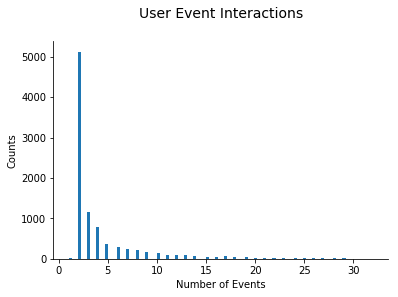

In [19]:
fig, ax = plt.subplots()
plot_histgram(event_per_user.values, ax,
                    title='User Event Interactions',
                    xlabel='Number of Events',
                    ylabel='Counts',
                     threshold=.99)

2. Find average users activity level for different btnClick event
    - A lot of users clicked the button 0 or 1 time.

In [20]:
def findBtnClick(x, getLength=True):
    # print(x)
    x = x.reset_index()
    x = x[x.event == 'btnClick']
    if getLength:
        return len(x.name.values)
    else:
        return list(set(x.name.values))
event_per_user = g_event.groupby('distinct_id').apply(findBtnClick)

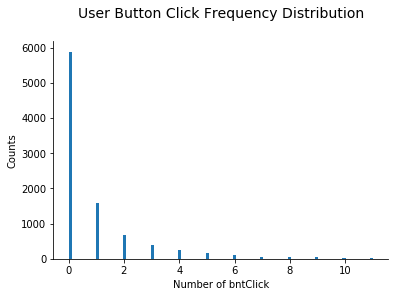

In [21]:
fig, ax = plt.subplots()
plot_histgram(event_per_user.values, ax,
                    title='User Button Click Frequency Distribution',
                    xlabel='Number of bntClick',
                    ylabel='Counts',
                     threshold=.99)

3. Which button is clicked most of the time?
    - request button is clicked the most.

In [22]:
click_event = g_event.groupby('distinct_id').apply(lambda x: findBtnClick(x, getLength=False)).values.squeeze()
clicked_user = list(filter(lambda x: len(x) != 0, click_event))

In [23]:
from collections import Counter
click_count = Counter([elem for item in clicked_user for elem in item])

click_x = [[v / len(clicked_user), k] for k, v in click_count.items()]
click_x.sort(key=lambda x: x[0])

Text(0.5,0,'Clicking Percentage')

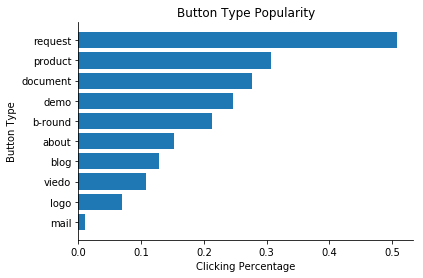

In [24]:
fig, ax = plt.subplots()
ax.barh([k[1] for k in click_x], [k[0] for k in click_x])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_title('Button Type Popularity')
ax.set_ylabel('Button Type')
ax.set_xlabel('Clicking Percentage')

4. Which pages have this user seen?
    - Most of people see the landing page.

In [25]:
def parseUrl(url):
    if url != url:
        return np.nan
    url = str(url)
    # print(str(url))
    try:
        x = re.search(r'[^(https://)]/.*', str(url))[0]
        x = x.split('/')[1]
        x = x.split('.')[0]
        
        if x[0] == '?':
            return 'landing'
        return x
    except:
        return 'landing'

page_see = g_event.groupby('distinct_id').apply(lambda x: list(set([parseUrl(l) for l in x['$url'] if l == l])))

page_see = page_see.values.squeeze()

page_count = Counter([e for i in page_see for e in i])

Text(0.5,0,'View Percentage')

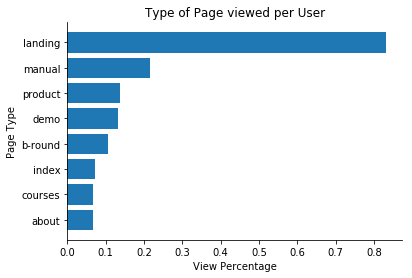

In [26]:
fig, ax = plt.subplots()
cand = sorted(page_count.most_common(8), key=lambda x: x[1], reverse=False)
ax.barh([k[0] for k in cand], [k[1] / len(g_event.index.unique()) for k in cand])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_title('Type of Page viewed per User')
ax.set_ylabel('Page Type')
ax.set_xlabel('View Percentage')

5. In which page did user click the request button for demo
    - Most of people who click the button for demo in landing page. Some of them click the button on demo page.

In [27]:
click_request = [[idx, v] for idx, v in zip(g_event[g_event.name == 'request'].pageUrl.apply(parseUrl).value_counts().index[:-2], 
                    g_event[g_event.name == 'request'].pageUrl.apply(parseUrl).value_counts().values[:-2])]

Text(0.5,0,'View Percentage')

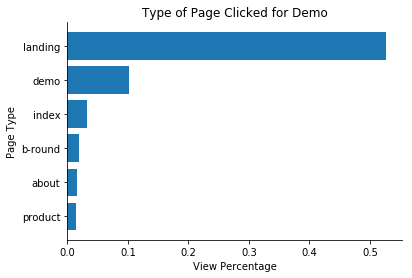

In [28]:
fig, ax = plt.subplots()
click_request = sorted(click_request, key=lambda x: x[1], reverse=False)
ax.barh([k[0] for k in click_request], [k[1] / len(clicked_user) for k in click_request])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_title('Type of Page Clicked for Demo')
ax.set_ylabel('Page Type')
ax.set_xlabel('View Percentage')

6. How long does the user take to convert?
    - The plot shows that most of the users click the submit button after first visit in around 1-4 minutes. Did they actually look into the about, demo, video pages? Or they just request demo without reading information.

In [33]:
def findConversionLength(x, action):
    # sort the time value
    x = x.sort_values('time')
    x = x[x.event != 'unknown event']
    x.index = np.arange(len(x))
#     print(x)
    # print(np.where(x['$is_first_time'])[0][0])
    # print(np.where(x['event'] == action)[0][0])
    # print(np.where(x['event'] == 'formSubmit')[0][0])
#     print(x.time[0])
    try:
        first_timestamp = x.time[np.where(x['$is_first_time'])[0][0]]
        submit_timestamp = x.time[np.where(x['event'] == action)[0][0]]
    except:
        first_timestamp = np.nan
        submit_timestamp = np.nan
    duration = submit_timestamp - first_timestamp
    return duration

conversion_length = g_full.groupby('distinct_id').apply(lambda x: findConversionLength(x, 'formSubmit'))

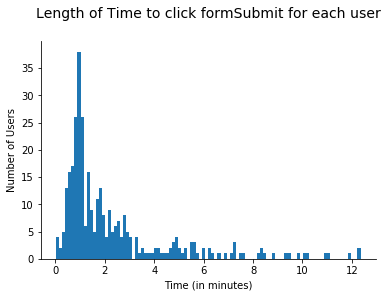

In [34]:
fig, ax = plt.subplots()
plot_histgram(conversion_length/60, ax,
                    title='Length of Time to click formSubmit for each user',
                    xlabel='Time (in minutes)',
                    ylabel='Number of Users',
                    threshold=.8)

6. Find conversion rate and visualize the funnel for conversion
    - Out of all users who view the page, only 20% of them click the request button for demo, and only 5% user who decide to sign up for demo.

In [35]:
# pageview - click_send_cellphone - verify_cellphone_code - formSubmit
def getEvent(x, focus):
    if focus == 'btnClick_request':
        k = x.copy()
        x1 = x.event == 'btnClick' 
        x1 = np.array([1 if j else 0 for j in x1.values])
        x2 = k.name == 'request'
        x2 = np.array([1 if x else 0 for x in x2.values])
        # x2 = np.array([1 if x else 0 for x in x2.values])
        find_ = list(filter(lambda x: x ==2, list(x1+x2)))
        return len(find_) > 0
        # print(x)
    else:
        x = x.event == focus
    
    return sum(x) > 0

funnel = ['$pageview', 'btnClick', 'btnClick_request', 'click_send_cellphone', 'verify_cellphone_code', 'formSubmit']
funnel_pct = []
for idx, elem in enumerate(funnel):
    v_ = sum(g_event.groupby('distinct_id').apply(lambda x: getEvent(x, elem)))
    funnel_pct.append(v_)

# g_event.head(50).groupby('distinct_id').apply(lambda x: getEvent(x, '$pageview'))

Text(0.5,0,'Funnel Percentage')

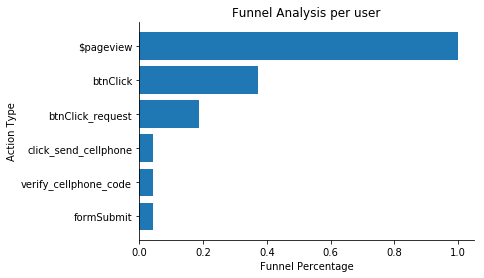

In [36]:
fig, ax = plt.subplots()
click_request = sorted(click_request, key=lambda x: x[1], reverse=False)
ax.barh(funnel[::-1], [k / unique_user for k in funnel_pct][::-1])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_title('Funnel Analysis per user')
ax.set_ylabel('Action Type')
ax.set_xlabel('Funnel Percentage')

In [37]:
g_analysis = pd.merge(
    g_analysis,
    pd.DataFrame(g_event.groupby('distinct_id').apply(lambda x: getEvent(x, 'formSubmit'))),
    left_index=True,
    right_index=True
)

g_analysis = g_analysis.rename(columns={0: 'converted'})

g_event.columns, g_analysis.columns

(Index(['time', 'event', 'pageUrl', '$url', 'pageStayTime', 'pagePosition',
        'name'],
       dtype='object'),
 Index(['$model', '$browser', '$utm_source', '$utm_medium', '$utm_campaign',
        '$utm_content', '$utm_term', '$is_first_time', '$ip', 'converted'],
       dtype='object'))

### 3. EDA cont.

1. The mobile user will probably has lower conversion rate than pc users

**Answer: Most of users who are using PC or laptop tend to be more likely to sign up for demo.**

In [38]:
g_analysis.loc[:,'mobile_binary'] = g_analysis['$model'].apply(lambda x: 0 if x in ['pc', 'mac'] else 1).copy()

pd.merge(
    g_analysis.groupby(['mobile_binary', 'converted']).agg({'mobile_binary': 'count'}),
    g_analysis.groupby(['mobile_binary', 'converted']).agg({'mobile_binary': 'count'}).groupby(level=0).apply(lambda x: round(x / x.sum() * 100, 2)),
    left_index=True,
    right_index=True).rename(columns={
    'mobile_binary_x': 'count',
    'mobile_binary_y': 'pct'
})

count    pct
mobile_binary converted              
0             False       6805  94.59
              True         389   5.41
1             False       2146  98.71
              True          28   1.29

2. The user who did not have any external referrer domain should be more likely to be converted

**Answer: Baidu appears to be the reference soruce that has the highest conversion rate.**

In [39]:
def getNewSource(x):
    if x != x:
        return 0
    elif x == 'baidu':
        return 1
    else:
        return 2
g_analysis.loc[:,'refer_source'] = g_analysis['$utm_source'].apply(getNewSource)

pd.merge(
    g_analysis.groupby(['refer_source', 'converted']).agg({'refer_source': 'count'}),
    g_analysis.groupby(['refer_source', 'converted']).agg({'refer_source': 'count'}).groupby(level=0).apply(lambda x: round(x / x.sum() * 100, 2)),
    left_index=True,
    right_index=True).rename(columns={
    'refer_source_x': 'count',
    'refer_source_y': 'pct'
})

count    pct
refer_source converted              
0            False       3189  96.34
             True         121   3.66
1            False       5041  94.86
             True         273   5.14
2            False        721  96.91
             True          23   3.09

3. See if the user explore the pages other than the landing page. We should expect higher conversion rate for the user who also explore the video, demo, about pages.

**Answer: Most of users who converted at least explore the website before signing up for a demo request**

In [40]:
g_event_pv = g_event[g_event['event'] == '$pageview'].copy()

def getRelevantView(x):
    if x in ['landing', False]:
        return 0
    else:
        return 1
g_analysis.loc[:,'relevant_view'] = g_event_pv['$url'].apply(lambda x: getRelevantView(parseUrl(x))).\
groupby('distinct_id').apply(lambda x: 0 if sum(x) == 0 else 1).copy()

In [41]:
g_analysis.groupby(['relevant_view', 'converted']).agg({'relevant_view': 'count'})

relevant_view
relevant_view converted               
0             False               4974
              True                  23
1             False               3977
              True                 394

5. If user interact with website more times, more likely to sign up

**Answer: Prior to conversion, a significant amount of users interact with product, b-round, demo and manual pages.**

**The 40% of user who convert see the demo page. However, in the population, only 15% user see the demo page. We probably need to think about expose our demo page to the users to increase the chance of converting.**

In [42]:
g_conversion = pd.merge(
    g_event,
    pd.DataFrame(g_analysis[g_analysis.converted == 1].converted),
    left_index = True,
    right_index = True
)

def earlyThanSubmit(x):
    x = x.reset_index()
    benchmark = min(x[x.event == 'formSubmit'].time)
    
    filter_ = x.time < benchmark
    return set([parseUrl(v) for v in x[filter_]['$url']])
# filter the values that has smaller value than formSubmit time
# parseUrl ['$url'] and create a set to store page view
# generate a long list and count the list
page_seen = [elem for ls in g_conversion.groupby('distinct_id').apply(earlyThanSubmit).values.squeeze() for elem in ls]

In [44]:
page_seen_sort

[(nan, 417),
 ('landing', 408),
 ('demo', 152),
 ('product', 74),
 ('b-round', 64),
 ('manual', 64),
 ('index', 44),
 ('courses', 32),
 ('about', 26),
 ('tools', 1)]

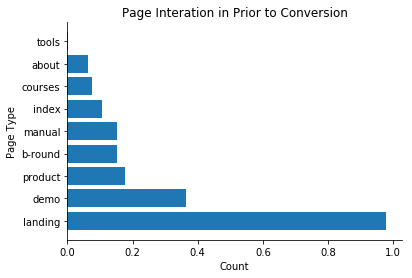

In [52]:
fig, ax = plt.subplots()
page_seen_sort = Counter(page_seen).most_common()
ax.barh([v[0] for v in page_seen_sort][1:], [v[1] / len(g_conversion.index.unique()) for v in page_seen_sort][1:])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_title('Page Interation in Prior to Conversion')
ax.set_ylabel('Page Type')
ax.set_xlabel('Count');

6. Other Findings.

Its weird to see only 10% users who click the request demo button in demo page (given that 40% of them actually view demo page). If the logic is correct, we shoud see almost 40% of users click for request on the demo page (it does not make sense for users to look at demo then go back to index page for request). We should reformat the demo page layout and allow user to access request button on demo page more easily.

In [53]:
def clickSubmit(x):
    x = x.reset_index()
    btn_time = x[x.event == 'btnClick'].time
    form_time = x[x.event == 'formSubmit'].time
    focus_filt = btn_time - min(form_time) < 0
    focus_ = btn_time - min(form_time)
    focus_min = max(focus_[focus_filt])
    focus_ = focus_.values
    focus_idx = np.where(focus_ == focus_min)[0][0]
    
    return parseUrl(x[x.event == 'btnClick']['pageUrl'].values[focus_idx])
click_btn = list(g_conversion.groupby('distinct_id').apply(clickSubmit))

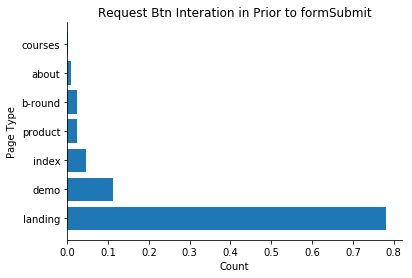

In [54]:
fig, ax = plt.subplots()
page_seen_sort = Counter(click_btn).most_common()
ax.barh([v[0] for v in page_seen_sort], [v[1] / len(g_conversion.index.unique()) for v in page_seen_sort])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_title('Request Btn Interation in Prior to formSubmit')
ax.set_ylabel('Page Type')
ax.set_xlabel('Count');

In [55]:
# get browser binary 
g_analysis['browser_binary'] = g_analysis['$browser'].apply(lambda x: 1 if x == 'chrome' else 0)

<hr>
### Summary

**INDEX = LANDING PAGE**
* number of events excluding leave events: most of user around 0, 1
* number of button clicked per user: most user around 0, 1 , 2, button click time
* type of button being clicked by user: request (0.5) > product (0.32) > document (0.3) > demo (0.28) > b-round (0.22) > about > blog > video
* time spend to click formsubmit button for each user: most people who convert spend < 4 mins
* Funnel: 100% viewed page > 20% click request button > 5% click formSubmit
* Most of users who are using PC or laptop tend to be more likely to sign up for demo.
* Baidu appears to be the reference soruce that has the highest conversion rate
* Most of users who converted at least explore the website before signing up for a demo request


* Comparison:
    * type of page viewed by **all user**: landing (0.85) > manual (0.23) > product (0.15) > demo (0.15) > b-round (0.13) > index (0.11) > courses (0.08)
    * type of page viewed by **converted user**: landing (1.0) > demo (0.4) > product (0.18) > b-round (0.17) > mannual (0.17) > courese (0.1)
* Comparison:
    * type of page **user** click request button for sign up: landing (0.55) > demo (0.13) > index (0.04) > b-round (0.02)
    * type of page **converted user** click request button for sign up: landing (0.80) > demo (0.10) > index (0.07) > product (0.02) > b-round (0.02)

<hr>

### 4.Model Building & Inference

**4 Steps**
1. Logitstic Regression model with limited amount of features (around 4)
2. Logistic Regression model with more features (around 15)
3. Logistic Regression model with bootstrap sampling technique to control class balance
4. Random Forest model for better performance

##### 1. Simple model with limited feature
* **mobile_binary:**
    * 0: laptop, PC
    * 1: mobile
* **refer_source:**
    * 0: no refer source
    * 1: baidu
    * 2: other
* **relevant_view:**
    * 0: only look at the landing page
    * 1: also explore pages other than landing page
* **browser_binary:**
    * 0: google
    * 1: others

In [459]:
# select four features to build logistic regression model for prediction
dummies = pd.get_dummies(g_analysis['refer_source'])
dummies = dummies.rename(columns={
    col: 'refer_source_%s'%col for col in dummies.columns
})
dummies = dummies.iloc[:,1:].copy()

g_model = g_analysis.loc[:,['mobile_binary', 'relevant_view', 'browser_binary']].copy()

g_model = g_model.join(dummies)
g_model = g_model.join(g_analysis['converted'])

In [145]:
# shallow logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

x = g_model.iloc[:,:-1].values

y = g_model.iloc[:,-1].values

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2, random_state=66)

lg_base = LogisticRegression()
lg_base.fit(xtrain, ytrain)

p_ytrain = lg_base.predict_proba(xtrain)[:,1]
p_ytest = lg_base.predict_proba(xtest)[:,1]

print('Train AUC: %s'%(np.round(roc_auc_score(ytrain, p_ytrain),2)))
print('Test AUC: %s'%(np.round(roc_auc_score(ytest, p_ytest),2)))

Train AUC: 0.83
Test AUC: 0.81


**Performance Evaluation**

From the Precision vs. Recall plot, we can see that the model is pretty bad because the AUC for this visualization is lower 0.2 and the overall precision is lower than 0.2 for every single recall.

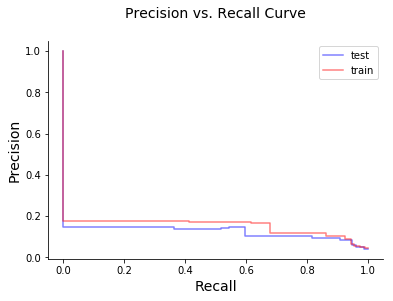

In [146]:
# I am using Precision vs. Recall curve in this case because of the imbalance nature of the data
from sklearn.metrics import precision_recall_curve
def pr_curve(xtrain, xtest, ytrain, ytest, model):
    p_ytrain = model.predict_proba(xtrain)[:,1]
    p_ytest = model.predict_proba(xtest)[:,1]
    
    precision_test, recall_test, _ = precision_recall_curve(ytest, p_ytest)
    precision_train, recall_train, _ = precision_recall_curve(ytrain, p_ytrain)
    
    fig, ax = plt.subplots()
    ax.step(recall_test, precision_test, color='b', alpha=0.5,
             where='post', label='test')
    ax.step(recall_train, precision_train, color='r', alpha=0.5,
             where='post', label='train')
    ax.legend(loc=1)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_title('Precision vs. Recall Curve', fontsize=14, y=1.08)
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    
pr_curve(xtrain, xtest, ytrain, ytest, lg_base)

##### 2. Logistic Regression model with more features (around 15)

* **Demographic**
    * Geo-location


* **User log behavior**
    * viewed related
        * number of events exclude leaving
        * number of btnClick
        * num_distinct_page_viewed (excluding landing page)
        * if_demo_viewed (type of page has been viewed by user)
        * num_consistent_btnclick_request
    * time related
        * time spend from the start to end
        * num_sessions
        * time spend on first sessions
        * max_inactivity_time
        * medium_inactivity_time

In [460]:
# Data Preprocessing 

# find the min time formSubmit event
def getMinFormSubmit(x):
    if sum(x.event == 'formSubmit') > 0:
        x_sub = x[x.event == 'formSubmit']
        return min(x_sub.time)
    else:
        return max(x.time)

# exclude the events later than the bench mark on user level
def formatEventData(df):
    df_temp = df[df.event != 'unknown event'].copy()
    print(df_temp.shape)
    benchmark = df_temp.groupby('distinct_id').apply(lambda x: getMinFormSubmit(x))
    benchmark = pd.DataFrame(benchmark, columns=['benchmark'])
    df_merge = df_temp.join(benchmark)
    df_merge['flag'] = df_merge['time'] <= df_merge['benchmark']
    df_merge = df_merge[df_merge.flag == True]
    print(df_merge.shape)
    return df_merge

def findEvents(x):
    x = x.event
    x = x[~x.isnull()]
    x_ = list(map(lambda x: False if re.search(r'leave$', x) else True, list(x)))
    return sum(x_)

g_eventT = formatEventData(g_event)

(46113, 7)
(40419, 9)


**Feature Engineering Step By Step**

1. number of events exclude leaving

In [461]:
g_model['num_events'] = g_eventT.groupby('distinct_id').apply(findEvents)

2. num of btnClick

In [462]:
def findBtnClick(x, getLength=True):
    # print(x)
    x = x.reset_index()
    x = x[x.event == 'btnClick']
    if getLength:
        return len(x.name.values)
    else:
        return len(list(set(x.name.values)))

In [463]:
g_model['num_btnclick'] = g_eventT.groupby('distinct_id').apply(findBtnClick)
g_model['num_btnclick_unique'] = g_eventT.groupby('distinct_id').apply(lambda x: findBtnClick(x, getLength=False))

3. distinct page viewed excluding landing and index page

In [464]:
g_eventT['url_parsed'] = g_eventT['$url'].apply(parseUrl)

def findDistinctPageView(x):
    x = x[~x.url_parsed.isnull()]
    x_list = list(filter(lambda x: x not in ['landing', 'index'], x.url_parsed.values))
    return len(set(x_list))
    print(list(filter(lambda x: x not in ['landing', 'index'], x.url_parsed.values)))

g_model['num_pageview_unique'] = g_eventT.groupby('distinct_id').apply(findDistinctPageView)

4. if_demo_viewed (type of page has been viewed by user)

In [465]:
g_model['view_demo'] = g_eventT.groupby('distinct_id').apply(lambda x: 1 if sum(x.url_parsed == 'demo') > 0 else 0)

5. Time Spend from Begin to End

In [466]:
g_model['life_time'] = g_eventT.groupby('distinct_id').apply(lambda x: max(x.time) - min(x.time))

6. number of sessions for each user + time spend on first session

In [467]:
# get the time difference between each steps
def getTimeDifferenceBetweenStep(x, interval=5):
    x_a = x.time.values[:-1]
    x_b = x.time.values[1:]

    x_diff = [b - a for a, b in zip(x_a, x_b)]
    
    session_idx = np.where(np.array(x_diff) >= (interval * 60))[0]
    # print(x_diff)

    if len(session_idx) > 0:
        session1 = sum(x_diff[:session_idx[0]])
    else:
        session1 = sum(x_diff)
        max_ = 0
        median_ = 0
    if len(x_diff) > 0:
        max_ = max(x_diff)
        median_ = np.median(np.array(x_diff))
    else: 
        max_ = 0
        median_ = 0
    
    return pd.Series([session1, len(session_idx) + 1, max_, median_], index=[
        'first_session_time', 'num_session', 'max_inactivity_time', 'median_inactivity_time'
    ])

In [468]:
g_modelT = g_model.join(g_eventT.groupby('distinct_id').apply(getTimeDifferenceBetweenStep))

6. difference between distinct num of btn click and num of btn click

In [469]:
g_modelT['btn_diff'] = g_modelT['num_btnclick'] - g_modelT['num_btnclick_unique'] 

**Training Logistic Regression**

In [470]:
x = g_modelT.loc[:,list(filter(lambda x: x != 'converted', g_modelT.columns))].values
y = g_modelT.loc[:,'converted'].values

In [158]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2, random_state=66)

lg_base = LogisticRegression()
lg_base.fit(xtrain, ytrain)

p_ytrain = lg_base.predict_proba(xtrain)[:,1]
p_ytest = lg_base.predict_proba(xtest)[:,1]

print('Train AUC: %s'%(np.round(roc_auc_score(ytrain, p_ytrain),2)))
print('Test AUC: %s'%(np.round(roc_auc_score(ytest, p_ytest),2)))

Train AUC: 0.97
Test AUC: 0.95


**Performance Evaluation**

We see considerable amount of improvement over the previous model. The AUC of this precision recall curve is greater than 0.5. However, there are still some issues. The trend we discovered in this precision vs. recall plot is not ideal. Ideally, we should have very high precision when we have low recall rate and we should see the precision decrease as the recall rate increase. This graph shows that our model performance is not very stable. It commited a lot False Positives when the recall rate is relatively low.

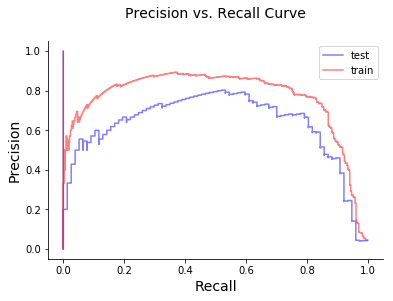

In [159]:
pr_curve(xtrain, xtest, ytrain, ytest, lg_base)

##### 3. Logistic Regression model with bootstraps for imbalance dataset (around 15)

In [160]:
from sklearn.utils import resample

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2, random_state=66)
n_sample = int(sum(ytrain == 0) / sum(ytrain == 1)) * sum(ytrain == 1) - sum(ytrain == 1)
x_add = resample(xtrain[np.where(ytrain == 1)[0],:], n_samples=n_sample)

# add to training set
xtrain_add = np.vstack([xtrain, x_add])
ytrain_add = np.vstack([ytrain.reshape(-1,1), np.ones(n_sample, dtype=int).reshape(-1,1)])
ytrain_add = ytrain_add.ravel()

pd.Series(ytrain_add).value_counts()

0    7154
1    7140
dtype: int64

In [161]:
lg_base = LogisticRegression()
lg_base.fit(xtrain_add, ytrain_add)

p_ytrain = lg_base.predict_proba(xtrain_add)[:,1]
p_ytest = lg_base.predict_proba(xtest)[:,1]

print('Train AUC: %s'%(np.round(roc_auc_score(ytrain_add, p_ytrain),2)))
print('Test AUC: %s'%(np.round(roc_auc_score(ytest, p_ytest),2)))

Train AUC: 0.98
Test AUC: 0.96


**Performance Evaluation**

Bootstrap sampling does not actually help the model to achieve better performance in this case. We still see the same curve for testing set.

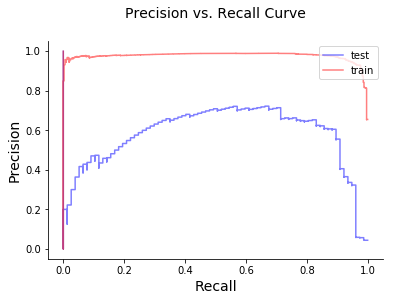

In [162]:
pr_curve(xtrain_add, xtest, ytrain_add, ytest, lg_base)

##### 4. Random Forest (around 15)

In [238]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=50)
rf.fit(xtrain, ytrain)

p_ytrain = rf.predict_proba(xtrain_add)[:,1]
p_ytest = rf.predict_proba(xtest)[:,1]

print('Train AUC: %s'%(np.round(roc_auc_score(ytrain_add, p_ytrain),2)))
print('Test AUC: %s'%(np.round(roc_auc_score(ytest, p_ytest),2)))

Train AUC: 1.0
Test AUC: 0.99


**Performance Evaluation**

We noticed that random forest are performaning a lot better compare to logistic regression. And in fact, over sample the positive class (user who churn) did help the model the precision.

AUC for Precision vs. Recall: 0.9040


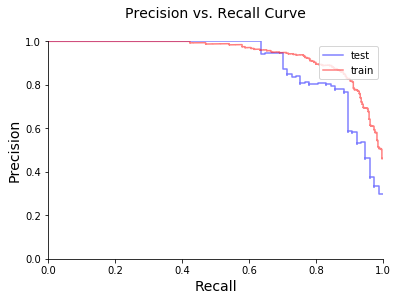

In [239]:
# without bootstrapping
pr_curve(xtrain, xtest, ytrain, ytest, rf)
print('AUC for Precision vs. Recall: %.4f'%pr_auc(ytest, rf.predict_proba(xtest)[:,1]))

AUC for Precision vs. Recall: 0.8797


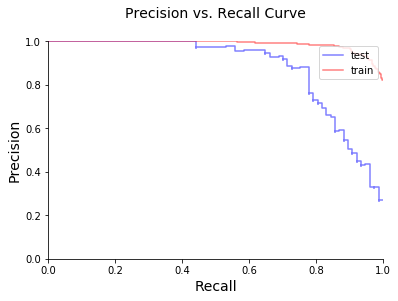

In [237]:
# with bootstrapping
pr_curve(xtrain, xtest, ytrain, ytest, rf)
print('AUC for Precision vs. Recall: %.4f'%pr_auc(ytest, rf.predict_proba(xtest)[:,1]))

In [223]:
def pr_auc(ytrue, ypred):
    p, r, t = precision_recall_curve(ytrue, ypred)
    # print(p.shape, r.shape)
    p_unique = []
    r_unique = []
    for precision, recall in zip(p, r):
        if recall in r_unique:
            if precision >p_unique[-1]:
                p_unique[-1] = precision
        else:
            p_unique.append(precision)
            r_unique.append(recall)
    
    r_arr = np.array(r_unique)
    
    r_calc = r_arr[:-1] - r_arr[1:]
    p_calc = np.array(p_unique)[:-1]
    
    # print(p_arr[1:].shape, p_arr[:-1].shape, r_calc.shape)
    result = r_calc * p_calc
    
    return sum(result)

In [241]:
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [291]:
# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [50, 100, 150],  # 50, 100
              'max_depth': [10, 15, 20],  # 5, 15
              'min_samples_leaf': [5, 10, 20], # 5, 20
              'class_weight': [{0:1, 1: 1}, {0:1, 1: 5}, {0:1, 1: 10}]
             }

pr_scorer = make_scorer(pr_auc)

In [ ]:
grid_clf = GridSearchCV(clf, param_grid, cv=5, scoring=pr_scorer)
grid_clf = grid_clf.fit(xtrain, ytrain)

In [295]:
grid_clf.best_params_

{'class_weight': {0: 1, 1: 5},
 'max_depth': 20,
 'min_samples_leaf': 5,
 'n_estimators': 50}

AUC for Precision vs. Recall: 0.9191


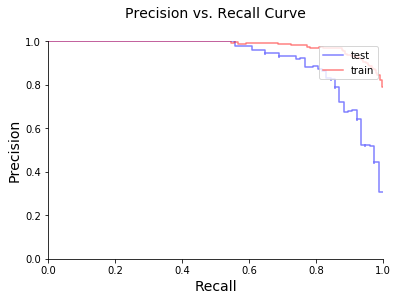

In [294]:
# with Gridsearch
pr_curve(xtrain, xtest, ytrain, ytest, grid_clf)
print('AUC for Precision vs. Recall: %.4f'%pr_auc(ytest, grid_clf.predict_proba(xtest)[:,1]))

In [472]:
# train the best model for prediction
best_rf = RandomForestClassifier(random_state=42)

best_rf.set_params(**grid_clf.best_params_)

best_rf.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 5},
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

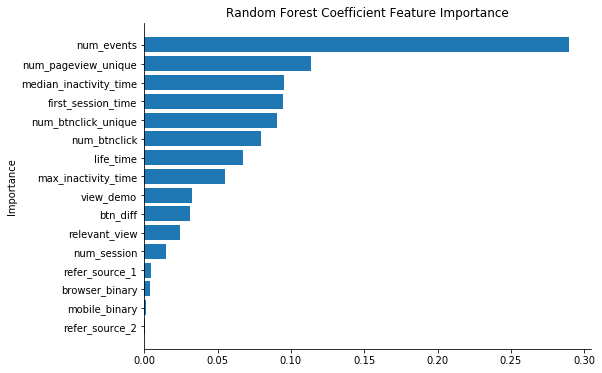

In [473]:
# visualization to understand the feature importance
def plotFeatureImportance(model, col_name):
    fig, ax = plt.subplots(figsize=(8,6))
    feature_importance = model.feature_importances_
    
    sort_idx = np.argsort(np.array(feature_importance))

    ax.barh(col_name[sort_idx], feature_importance[sort_idx])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.set_title('Random Forest Coefficient Feature Importance')
    ax.set_ylabel('Variable Name')
    ax.set_ylabel('Importance')
plotFeatureImportance(best_rf, g_modelT.drop(columns='converted').columns)

People who converted generally spending around 6 - 20 seconds to browsing the current page. People who did not convert either spend too less amount of time (1 - 5 seconds per page) or too much time ( > 60 seconds) on a page. 

Therefore, I suggest the company need to focus on adjusting the content of the page to make the content for each page interesting enough to allow user spend several seconds to glance through. On the other hand, the company need to make the content easy to read (reasonable amount of words and images).

Text(0,0.5,'Proportion')

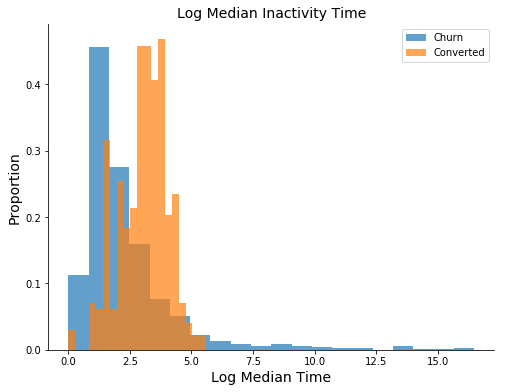

In [407]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
plot_histgram(np.log2(g_modelT[(g_modelT.converted == 0) & \
                    (g_modelT.num_events > 5)].median_inactivity_time.values + 1), ax, alpha=.7, label='Churn', bins=20,
                     density=True)
plot_histgram(np.log2(g_modelT[(g_modelT.converted == 1) & \
                    (g_modelT.num_events > 5)].median_inactivity_time.values + 1), ax, alpha=.7, label='Converted', bins=20,
                     density=True)
ax.set_title('Log Median Inactivity Time', fontsize=14)
ax.legend(loc=1)
ax.set_xlabel('Log Median Time', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)

### 5. More Feature Engineering

In [ ]:
# a lot variables correlate with each other, not really good for inference
# need to do further feature engineering

In [ ]:
# drop num_pageview_unique
# create effective_page_view

In [474]:
def findEffectivePageView(x):
    x = x[~x.url_parsed.isnull()]
    x_list = list(filter(lambda x: x not in ['landing', 'index'], x.url_parsed.values))
    distinct_view = len(set(x_list))
    total_view = len(x_list) + 0.0001
    return distinct_view / total_view

g_modelT['effective_page_view'] = g_eventT.groupby('distinct_id').apply(findEffectivePageView)

In [475]:
# drop num_btnclick + btn_diff
# create effective_btnclick

In [476]:
g_modelT['effective_btnclick'] = g_modelT.num_btnclick_unique / (g_modelT.num_btnclick + 0.0001)

In [477]:
# num_events is biased measurement because user need to take at least three events to click the formSubmit.
# And interestingly, there appears to be no difference between churn user and converted user in terms of their event activity
# Lets create a binary class for model to understand the situation better
# drop num_events
g_modelT['event_greater_than_3'] = g_modelT['num_events'].apply(lambda x: 1 if x > 3 else 0)

In [425]:
g_modelT[g_modelT.num_events <= 3].groupby(['converted']).agg({'num_events': 'count'})

,num_events
converted,
False,7079
True,14


In [427]:
g_modelT[g_modelT.num_events > 3].groupby(['converted']).agg({'num_events': 'median'})

,num_events
converted,
False,7
True,8


**Since we are using model to draw insight from the data, I think for now, we need to exclude every single user whose num_events is less than 3 for a more reliable estimation. Otherwise, the model will prune to produce biased results.**

In [511]:
# get rid of samples that are not helpful for the model
g_model_refine = g_modelT[g_modelT.num_events > 3]

# drop unwanted columns 
g_model_refine = g_model_refine.drop(columns=['effective_page_view', 'btn_diff', 'num_events', 'max_inactivity_time'])

print(g_model_refine.shape)

(2275, 16)


In [518]:
g_model_refine.converted.value_counts()

False    1872
True      403
Name: converted, dtype: int64

In [519]:
# build model again to see how it performed
x = g_model_refine.loc[:,g_model_refine.drop(columns='converted').columns].values
y = g_model_refine.loc[:,'converted'].values
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2, random_state=66)

In [521]:
# Choose the type of classifier. 
clf = RandomForestClassifier(random_state=42)

# Choose some parameter combinations to try
param_grid = {'n_estimators': [50, 100, 150],  # 50, 100
              'max_depth': [10, 15, 20],  # 5, 15
              'min_samples_leaf': [5, 10, 20], # 5, 20
              'class_weight': [{0:1, 1: 1}, {0:1, 1: 2}, {0:1, 1: 4}]
             }

pr_scorer = make_scorer(pr_auc)

In [522]:
grid_clf = GridSearchCV(clf, param_grid, cv=5, scoring=pr_scorer)
grid_clf = grid_clf.fit(xtrain, ytrain)

AUC for Precision vs. Recall: 0.7827


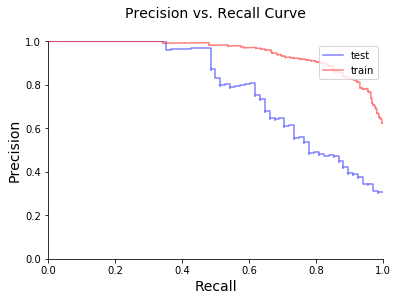

In [523]:
# with Gridsearch
pr_curve(xtrain, xtest, ytrain, ytest, grid_clf)
print('AUC for Precision vs. Recall: %.4f'%pr_auc(ytest, grid_clf.predict_proba(xtest)[:,1]))
# try to build logistic regression model this time
# any other extra insights?

In [525]:
# train the best model for prediction
best_rf = RandomForestClassifier(random_state=42)

best_rf.set_params(**grid_clf.best_params_)

best_rf.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 4},
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

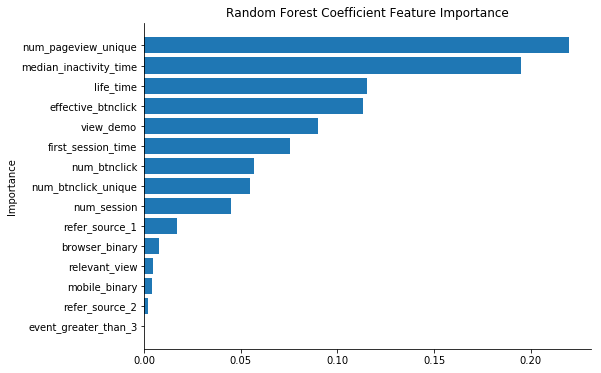

In [526]:
plotFeatureImportance(best_rf, g_model_refine.drop(columns='converted').columns)

Text(0.5,1,'Unique Page View Distribution excluding landing page')

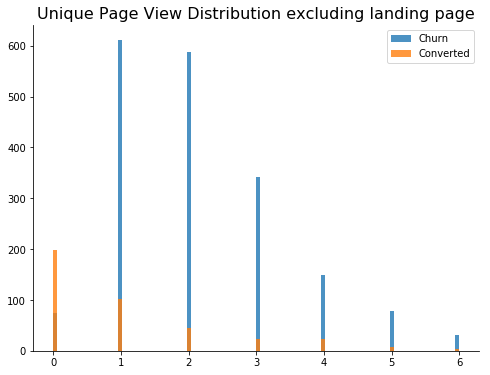

In [530]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
plot_histgram(g_model_refine[g_model_refine.converted == 0].num_pageview_unique, ax, alpha=.8, label='Churn')
plot_histgram(g_model_refine[g_model_refine.converted == 1].num_pageview_unique, ax, alpha=.8, label='Converted')
ax.legend(loc=1)
ax.set_title('Unique Page View Distribution excluding landing page', fontsize=16)

Text(0,0.5,'Proportion')

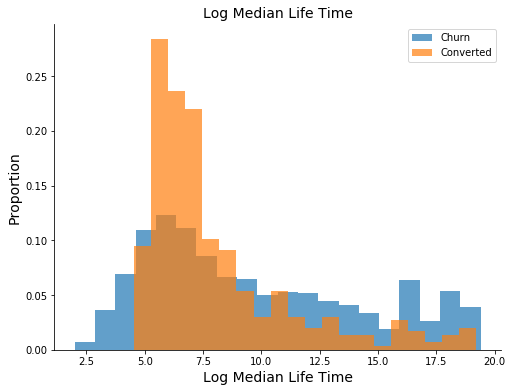

In [532]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
plot_histgram(np.log2(g_model_refine[(g_model_refine.converted == 0)].life_time.values + 1), ax, alpha=.7, label='Churn', bins=20,
                     density=True)
plot_histgram(np.log2(g_model_refine[(g_model_refine.converted == 1)].life_time.values + 1), ax, alpha=.7, label='Converted', bins=20,
                     density=True)
ax.set_title('Log Median Life Time', fontsize=14)
ax.legend(loc=1)
ax.set_xlabel('Log Median Life Time', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)

In [557]:
np.log2(120)

6.906890595608519

Text(0.5,1,'Effective Buttom Click Distribution excluding landing page')

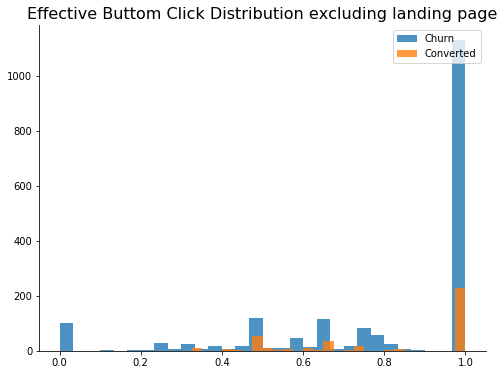

In [560]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
plot_histgram(g_model_refine[g_model_refine.converted == 0].effective_btnclick, ax, alpha=.8, label='Churn', bins=30)
plot_histgram(g_model_refine[g_model_refine.converted == 1].effective_btnclick, ax, alpha=.8, label='Converted', bins=30)
ax.legend(loc=1)
ax.set_title('Effective Buttom Click Distribution excluding landing page', fontsize=16)

## Findings & Recommendation

**Findings:**
1. Compare to user activity information, the Effect of Reference Source, Mobile, Browser is pretty minimal
2. Most of users who converted spend reasonable time between pages 8 - 20 seconds per page
3. People who viewed demo page are more likely to be converted
4. Almost 50% people who converted, directly clicked the request button for demo request on the landing page without exploring other pages.
5. The lifetime for most converted users is around 2 minutes.
6. Around 100+ churn users has very low value in effective btn click feature.


**Recommendations:**
1. We may need to find a better way to do the marketing strategies. From the finding, **we did not see difference among marketing campaign in terms of conversion performance**. The likehood of conversion is highly depend on users' interaction with the website.
2. Optimize the content of the web page. Control the reading time in **8 - 20 seconds** per page range.
3. **Made the demo page button standout** in the landing page so that user are more likely to view the demo page because people who virewed the demo page are more likely to convert.
4. 50% of converted users submit demo request directly from the landing page. This means that landing page is attractive enough for user to click the convert button. However, a considerable amount of users who did not request demo on the landing page. This might due to the fact that they need more information about the product. Therefore, we still need to **optimize other pages to provide additional information**.
5. We need to made our **website easier to interact and faster to response**.
6. low value in effective btn click feature indicates that these users are **experiencing response lantancy** from the website. So we need to do some adjsutment on the server sides to optimize user experience.